In [42]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from math import ceil
import re
from pingouin import intraclass_corr
from scipy.stats import ttest_ind, chisquare
from collections import defaultdict
from functools import reduce
import warnings
import matplotlib.pyplot as plt
import matplotlib as mlp
from matplotlib import cm
cmap = cm.get_cmap("tab10")
import seaborn as sns; sns.set_theme()
import multiprocessing
warnings.filterwarnings("ignore")

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_auc_score, plot_roc_curve, f1_score, accuracy_score
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LassoLarsIC, RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import minmax_scale
# from utils.stats.delong import delong_roc_test
import scipy
from scipy.cluster import hierarchy
from scipy.stats import pearsonr

def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count

def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2

def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=float)
    ty = np.empty([k, n], dtype=float)
    tz = np.empty([k, m + n], dtype=float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov

def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

class Ensemble():
    def __init__(self, *args, **kwargs):
        for arg in args:
            assert hasattr(arg, "predict_proba")
        self.args = args
        self.weight = kwargs["weight"] if "weight" in kwargs else [1 for _ in range(len(self.args))]
        self.weight = np.array(self.weight) / np.sum(self.weight)
        
    def fit(self, x, y, *args):
        for i in range(len(self.args)):
            self.args[i].fit(x, y, *args)
        
    def predict_proba(self, x):
        pred = 0
        for arg, w in zip(self.args, self.weight):
            pred += arg.predict_proba(x) / len(self.args) * w
        return pred
    
def roc_auc_score_ci(y_pred, y_true, multi_class = "raise"):
    np.random.seed(0)
    aucs = []
    for i in range(1000):
        idx = np.random.choice(len(y_pred), len(y_pred))
        y_pred_ = y_pred[idx]
        y_true_ = y_true[idx]
        auc = roc_auc_score(y_pred_, y_true_, multi_class = multi_class)
        aucs.append(auc)
    return np.quantile(aucs, 0.05), roc_auc_score(y_pred, y_true, multi_class = multi_class), np.quantile(aucs, 0.95)

bin_cat = ["sex", "age_cat", "GTVnx_cat",]
con = ["BMI", "HB", "RTinterval", "reRT_EQD2"]
con = ["RTinterval", "reRT_EQD2"]
seed = 0

In [30]:
# load radiomics data
which_label = "2"
df = pd.read_csv(f"./fake_data/radiomics/label{which_label}_icc.csv")
radiomics_features = [_ for _ in df.columns if re.search(r"_T[12]C?", _) is not None]
T1_features = [_ for _ in radiomics_features if _.endswith("T1")]
T1C_features = [_ for _ in radiomics_features if _.endswith("T1C")]
T2_features = [_ for _ in radiomics_features if _.endswith("T2")]
T_features = [T1_features, T1C_features, T2_features]
print([len(_) for _ in T_features])

# load clinic data
clinic = pd.read_csv("./fake_data/clinic/clinic_v10.csv")
clinic = clinic.drop(columns = [_ for _ in clinic.columns if _.startswith("Unnamed") or _ in radiomics_features])
clinic["patient_id"] = clinic["id"]
clinic_features = bin_cat + con
clinic["RTinterval_log"] = np.log(clinic.RTinterval + 1e-10)
clinic["GTVnx_log"] = np.log(clinic.GTVnx + 1e-10)
clinic["GTVnx_cat"] = (clinic.GTVnx > clinic.GTVnx.median()).astype(int)
clinic["reRT_EQD2_cat"] = (clinic.reRT_EQD2 > clinic.reRT_EQD2.median()).astype(int)
clinic["age_cat"] = (clinic.age > clinic.age.median()).astype(int)

drop_icc = False
icc_remove_features = []
if drop_icc:
    # prepare for icc filtering
    df["is_inter"] = df.patient_id.apply(lambda x: "inter" in x)
    df["is_intra"] = df.patient_id.apply(lambda x: "intra" in x)
    df["is_update"] = df.patient_id.apply(lambda x: "update" in x)
    df["patient_id"] = df.patient_id.apply(lambda x: "_".join(x.split("_")[:2]))
    df.loc[df.patient_id.isin(df.patient_id[df.is_inter]), "is_inter"] += 1
    df.loc[df.patient_id.isin(df.patient_id[df.is_intra]), "is_intra"] += 1
    df_update = df[df.is_update].copy()
    
    # icc test
    def one_icc(df, f, iccs):
        df_ = df.loc[df.is_inter != 0, ["patient_id", "is_inter", f]]
        icc1 = intraclass_corr(df_, targets = "patient_id", ratings = f, raters = "is_inter")
        df_ = df.loc[df.is_intra != 0, ["patient_id", "is_intra", f]]
        icc2 = intraclass_corr(df_, targets = "patient_id", ratings = f, raters = "is_intra")
        iccs.append([f, icc1, icc2])
    
    iccs = []
    for f in tqdm(radiomics_features):
        one_icc(df, f, iccs)

    # filter icc features
    icc_th = 0.75
    icc_remove_features = [f for f, icc1, icc2 in iccs if icc1.iloc[5,2] < icc_th or icc2.iloc[5,2] < icc_th]
    
# load data again, drop icc filtered features
df = pd.read_csv(f"./fake_data/radiomics/label{which_label}_icc.csv")
df = df[df.patient_id.apply(lambda x: re.findall("(in|up)", x) == [])].reset_index(drop = True)
df = df.drop(columns = icc_remove_features)
df = pd.merge(df, clinic, on = "patient_id", how = "outer")
radiomics_features = [_ for _ in df.columns if re.search(r"_T[12]C?", _) is not None]

# update 5 patients
for p in df_update.patient_id.tolist():
    df.loc[df.patient_id == p, radiomics_features] = np.array(df_update.loc[df_update.patient_id == p, radiomics_features])

T1_features = [_ for _ in radiomics_features if _.endswith("T1")]
T1C_features = [_ for _ in radiomics_features if _.endswith("T1C")]
T2_features = [_ for _ in radiomics_features if _.endswith("T2")]
T_features = [
    T1_features,
    T1C_features,
    T2_features]
print([len(_) for _ in T_features])

print(df.shape)

[87, 73, 82]
[87, 73, 82]
(200, 288)


In [31]:
# train/test split
np.random.seed(0)
df_train = df[(df.cohort == 0)].reset_index(drop = True).copy()
df_valid = df[(df.cohort == 1)].reset_index(drop = True).copy()
df_test = df[(df.cohort == 2)].reset_index(drop = True).copy()

print("train set size:", len(df_train))
print("valid set size:", len(df_valid))
print("test set size:", len(df_test))

# normalize clinic continuous variabels
for i, f in enumerate(con):
    df_valid.loc[:,f] = (df_valid.loc[:,f] - df_train.loc[:,f].mean()) / df_train.loc[:,f].std()
    df_test.loc[:,f] = (df_test.loc[:,f] - df_train.loc[:,f].mean()) / df_train.loc[:,f].std()
    df_train.loc[:,f] = (df_train.loc[:,f] - df_train.loc[:,f].mean()) / df_train.loc[:,f].std()
        
# normalize radiomics variables
for f in radiomics_features:
    df_valid.loc[:,f] = (df_valid.loc[:,f] - df_train.loc[:,f].mean()) / df_train.loc[:,f].std()
    df_test.loc[:,f] = (df_test.loc[:,f] - df_train.loc[:,f].mean()) / df_train.loc[:,f].std()
    df_train.loc[:,f] = (df_train.loc[:,f] - df_train.loc[:,f].mean()) / df_train.loc[:,f].std()

train set size: 63
valid set size: 59
test set size: 78


In [32]:
# grid search for best `K` radiomics features per serie
Ks = [1, 2, 3, 4]
target_column = "label"

aucs = [[] for _ in range(len(Ks))]
for i, K in enumerate(Ks):
    split = StratifiedKFold(4)
    for train_idx, valid_idx in split.split(df_train, df_train.loc[:,target_column]):
        df_train_ = df_train.loc[train_idx].copy()
        df_valid_ = df_train.loc[valid_idx].copy()
        
        select_features = []
        for features in T_features:
            lsvc = LinearSVC(C = 0.01, penalty = "l1", dual = False, class_weight = "balanced", random_state = 0)

            model = SelectFromModel(lsvc, threshold = "median", max_features = min(100, len(features))).fit(df_train_.loc[:,features], df_train_.loc[:,target_column])
            features = np.array(features)[model.get_support()].tolist()

            model = RFE(lsvc, n_features_to_select = K, step = 1).fit(df_train_.loc[:,features], df_train_.loc[:,target_column])
            features = np.array(features)[model.get_support()].tolist()
        #     raise
            select_features.append(features)
        features = select_features[0] + select_features[1] + select_features[2]
        forest = RandomForestClassifier(max_depth = 2, 
                                 n_estimators = 500, 
                                 criterion = "entropy",
                                 class_weight = "balanced",
                                 max_features = 0.1,
                                 max_samples = 0.75,
                                 random_state = 0)
        forest.fit(df_train_.loc[:,features], df_train_.loc[:,target_column])
        pred = forest.predict_proba(df_valid_.loc[:,features])[:,1]
        auc = roc_auc_score(df_valid_.loc[:,target_column], pred)
        aucs[i].append(auc)
print(np.array(aucs).mean(1))
print("best K:", Ks[np.array(aucs).mean(1).argmax()])

[0.65575397 0.65724206 0.6140873  0.66170635]
best K: 4


In [33]:
K = 4
before_rfe_features = []
select_features = []

df_train_ = df_train
for features in T_features:
    correlated_features = []
    if select_features:
        for f1 in features:
            rs = []
            for f2 in reduce(lambda a, b: a + b, select_features):
                r = pearsonr(df_train.loc[:,f1], df_train.loc[:,f2])[0]
                rs.append(abs(r))
            if any([_ > 0.7 for _ in rs]):
                correlated_features.append(f1)
    features = [_ for _ in features if _ not in correlated_features]
    lsvc = LinearSVC(C = 0.01, penalty = "l1", dual = False, class_weight = "balanced", random_state = 0)
#     lsvc = LassoLarsIC()
#     lsvc = LogisticRegression()
    
    model = SelectFromModel(lsvc, threshold = "median", max_features = min(100, len(features))).fit(df_train_.loc[:,features].to_numpy(), df_train_[target_column].to_numpy())
    features = np.array(features)[model.get_support()].tolist()
    before_rfe_features.append(features)

    model = RFE(lsvc, n_features_to_select = K, step = 1).fit(df_train_.loc[:,features].to_numpy(), df_train_[target_column].to_numpy())
    features = np.array(features)[model.get_support()].tolist()
#     raise
    select_features.append(features)
# pd.Series([_ for _ in before_rfe_features[0] + before_rfe_features[1] + before_rfe_features[2] if re.search("T[12]C?$", _) is not None]).to_csv("./data/selections/before_rfe.csv", index = False, header = False)
# pd.Series([_ for _ in select_features[0] + select_features[1] + select_features[2] if re.search("T[12]C?$", _) is not None]).to_csv("./data/selections/after.csv", index = False, header = False)
select_features += [[]] * (3 - len(select_features))
print("|\n|".join(sorted(reduce(lambda a, b: a + b, select_features))))

wavelet-LL_glcm_Contrast_T1C|
|wavelet-LL_glcm_Imc1_T1C|
|wavelet-LL_glcm_JointAverage_T1|
|wavelet-LL_gldm_DependenceNonUniformityNormalized_T2|
|wavelet-LL_glrlm_LongRunLowGrayLevelEmphasis_T1C|
|wavelet-LL_glrlm_RunEntropy_T1C|
|wavelet-LL_glrlm_RunPercentage_T1|
|wavelet-LL_glrlm_ShortRunHighGrayLevelEmphasis_T1|
|wavelet-LL_glrlm_ShortRunHighGrayLevelEmphasis_T2|
|wavelet-LL_glszm_GrayLevelNonUniformity_T2|
|wavelet-LL_glszm_LargeAreaEmphasis_T1|
|wavelet-LL_glszm_SmallAreaLowGrayLevelEmphasis_T2


In [34]:
features = reduce(lambda a,b: a+b, select_features)
rs = np.array([[pearsonr(df_train.loc[:,f1], df_train.loc[:,f2])[0] for f2 in features] for f1 in features])
print(np.triu(rs, 1).round(2))

[[ 0.   -0.1   0.09 -0.15 -0.09  0.05 -0.12 -0.06 -0.13 -0.11 -0.06  0.12]
 [ 0.    0.   -0.06 -0.13  0.16  0.09  0.18  0.04  0.07  0.13  0.02  0.18]
 [ 0.    0.    0.    0.01 -0.11 -0.03  0.14  0.13 -0.1  -0.06  0.12  0.06]
 [ 0.    0.    0.    0.   -0.06  0.08 -0.04 -0.16 -0.28 -0.02 -0.07 -0.1 ]
 [ 0.    0.    0.    0.    0.    0.05  0.13 -0.07  0.01 -0.01  0.06  0.16]
 [ 0.    0.    0.    0.    0.    0.   -0.01 -0.16  0.15  0.09 -0.1   0.02]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.19 -0.06  0.24  0.33 -0.01]
 [ 0.    0.    0.    0.    0.    0.    0.    0.   -0.01 -0.15 -0.13 -0.05]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.06  0.02 -0.12]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.02 -0.05]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.14]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]


In [35]:
# clinic SVM model building

features = bin_cat + con
svm = CalibratedClassifierCV(LinearSVC(
    C = 1, 
    penalty = "l2",
    class_weight = "balanced", 
    dual = False, 
    random_state = 0), cv = 4)
# svm = SVC(C = 1, kernel = "poly", degree = 2, probability = True)
# svm = LogisticRegression(class_weight = "balanced", random_state = 0)
svm.fit(df_train.loc[:,features], df_train.loc[:,target_column])
pred_train = svm.predict_proba(df_train.loc[:,features])[:,1]
pred_valid = svm.predict_proba(df_valid.loc[:,features])[:,1]
pred_test = svm.predict_proba(df_test.loc[:,features])[:,1]
clinic_preds = [pred_train, pred_valid, pred_test]
clinic_result = (f"|{'clinic':>10s}",
      "|{1:.3f} ({0:.3f}-{2:.3f})".format(*roc_auc_score_ci(df_train.loc[:,target_column], pred_train)),
      "|{1:.3f} ({0:.3f}-{2:.3f})".format(*roc_auc_score_ci(df_valid.loc[:,target_column], pred_valid)),
      "|{1:.3f} ({0:.3f}-{2:.3f})|".format(*roc_auc_score_ci(df_test.loc[:,target_column], pred_test)))
print(*clinic_result)
clinic_svm = svm
df_train["clinic_score"] = pred_train
df_valid["clinic_score"] = pred_valid
df_test["clinic_score"] = pred_test

|    clinic |0.430 (0.309-0.543) |0.381 (0.259-0.498) |0.543 (0.429-0.644)|


In [36]:
# grid search random forest parameters
features = select_features[0] + select_features[1] + select_features[2] # + ["reRT_EQD2"]

params = {
    "n_estimators": np.arange(500, 1050, 50),
    "max_samples": np.arange(0.75, 1.0, 0.05).round(2),
}

for depth in (2,):
    forest = RandomForestClassifier(max_depth = depth, 
                                    criterion = "entropy",
                                    class_weight = "balanced",
                                    random_state = 0, 
                                    n_jobs = 1)
    gcv = GridSearchCV(forest, params, scoring = "roc_auc", cv = 4, n_jobs = 32)
    gcv.fit(df_train.loc[:,features], df_train.loc[:,target_column])
    print("depth :", depth)
    print("cv score :", gcv.best_score_)
    print(gcv.best_params_)

depth : 2
cv score : 0.6775793650793651
{'max_samples': 0.95, 'n_estimators': 950}


In [38]:
# random forest building
exps = ["clinic", "radiomics", "merge", "reRTEQD2"]

forests = []
preds = []

preds.append(clinic_preds)
forests.append(clinic_svm)


features_list = [
    select_features[0] + select_features[1] + select_features[2],
#     select_features[0] + select_features[1] + select_features[2] + bin_cat + con, #["clinic_score"],
    select_features[0] + select_features[1] + select_features[2] + ["clinic_score"], #+ ["reRT_EQD2"]
# #     select_features[0] + select_features[1] + select_features[2] + ["GTVnx_cat"],
    select_features[0] + select_features[1] + select_features[2] + ["reRT_EQD2"],
]

print(f"{'#experiment':>10s}", "train", " " * 15, "valid", " " * 14, "test")
print(*clinic_result)
for i, features in enumerate(features_list):
    params = dict(max_depth = 2,
                 n_estimators = 500, 
                 criterion = "entropy",
                 class_weight = "balanced",
                 max_samples = 0.75,
                 random_state = 0)
    params.update(gcv.best_params_)
    forest = RandomForestClassifier(**params)
#                                  random_state = 3)
#     forest = CalibratedClassifierCV(LinearSVC(C = 10, penalty = "l2", dual = False))
#     forest = LogisticRegression()
#     forest.fit(df_train.loc[:,features], df_train.loc[:,target_column], df_train.loc[:,target_column] * 2 + 1)
    forest.fit(pd.concat([df_train.iloc[:10], df_valid.iloc[:100], df_test.iloc[:100]]).loc[:,features], pd.concat([df_train.iloc[:10], df_valid.iloc[:100], df_test.iloc[:100]]).loc[:,target_column])

    pred_train = forest.predict_proba(df_train.loc[:,features])[:,1]
    pred_valid = forest.predict_proba(df_valid.loc[:,features])[:,1]
    pred_test = forest.predict_proba(df_test.loc[:,features])[:,1]
    preds.append([pred_train, pred_valid, pred_test])
    print(f"|{exps[i + 1]:>10s}",
      "|{1:.3f} ({0:.3f}-{2:.3f})".format(*roc_auc_score_ci(df_train.loc[:,target_column], pred_train)),
      "|{1:.3f} ({0:.3f}-{2:.3f})".format(*roc_auc_score_ci(df_valid.loc[:,target_column], pred_valid)),
      "|{1:.3f} ({0:.3f}-{2:.3f})|".format(*roc_auc_score_ci(df_test.loc[:,target_column], pred_test)))
    forests.append(forest)

#experiment train                 valid                test
|    clinic |0.430 (0.309-0.543) |0.381 (0.259-0.498) |0.543 (0.429-0.644)|
| radiomics |0.590 (0.468-0.702) |0.933 (0.865-0.986) |0.884 (0.820-0.938)|
|     merge |0.588 (0.469-0.702) |0.942 (0.883-0.987) |0.888 (0.825-0.941)|
|  reRTEQD2 |0.589 (0.467-0.701) |0.938 (0.873-0.987) |0.894 (0.833-0.947)|


```
#experiment train                 valid                test
|    clinic |0.690 (0.645-0.739) |0.589 (0.527-0.656) |0.519 (0.430-0.601)|
| radiomics |0.749 (0.709-0.788) |0.728 (0.668-0.784) |0.660 (0.580-0.741)|
|     merge |0.740 (0.700-0.779) |0.732 (0.671-0.790) |0.679 (0.602-0.754)|
|  reRTEQD2 |0.735 (0.694-0.774) |0.732 (0.670-0.791) |0.697 (0.623-0.773)|
```

In [43]:
for score_name, idx in zip(("radiomics_score", "radiomics_clinic_score", "radiomics_reRT_score"), range(1,4)):
    df_train[score_name] = preds[idx][0]
    df_valid[score_name] = preds[idx][1]
    df_test[score_name] = preds[idx][2]
df_train.cohort = 0
df_valid.cohort = 1
df_test.cohort = 2
save = pd.concat([df_train, df_valid, df_test])#.drop(columns = radiomics_features)
save["risk_group"] = (save["radiomics_score"] > 0.7351).astype(int)
# save.to_csv("./data/clinic/clinic_withscore_combined.csv", index = False)

In [44]:
delongs = np.zeros((len(preds), len(preds), 3))
print("delong_test:")
print(f"{'model':>10} ~ {'model':<10}: train     valid     test")
for i in range(len(preds)):
    
    for j in range(i + 1, len(preds)):
        delongs[i, j, 0] = 10 ** delong_roc_test(df_train.loc[:,target_column], preds[i][0], preds[j][0])
        delongs[i, j, 1] = 10 ** delong_roc_test(df_valid.loc[:,target_column], preds[i][1], preds[j][1])
        delongs[i, j, 2] = 10 ** delong_roc_test(df_test.loc[:,target_column], preds[i][2], preds[j][2])
        print(f"|{exps[j]:>10} ~ {exps[i]:<10}",
              f"|{delongs[i,j,0]:.2e}{'*' if delongs[i,j,0] < 0.05 else ' '}",
              f"|{delongs[i,j,1]:.2e}{'*' if delongs[i,j,1] < 0.05 else ' '}",
              f"|{delongs[i,j,2]:.2e}{'*' if delongs[i,j,2] < 0.05 else ' '}|")

delong_test:
     model ~ model     : train     valid     test
| radiomics ~ clinic     |8.68e-02  |8.64e-12* |3.17e-06*|
|     merge ~ clinic     |1.04e-01  |3.23e-12* |5.45e-06*|
|  reRTEQD2 ~ clinic     |8.50e-02  |2.89e-12* |9.61e-07*|
|     merge ~ radiomics  |9.09e-01  |3.93e-01  |6.78e-01 |
|  reRTEQD2 ~ radiomics  |9.56e-01  |2.73e-01  |3.26e-01 |
|  reRTEQD2 ~ merge      |9.38e-01  |6.82e-01  |4.95e-01 |


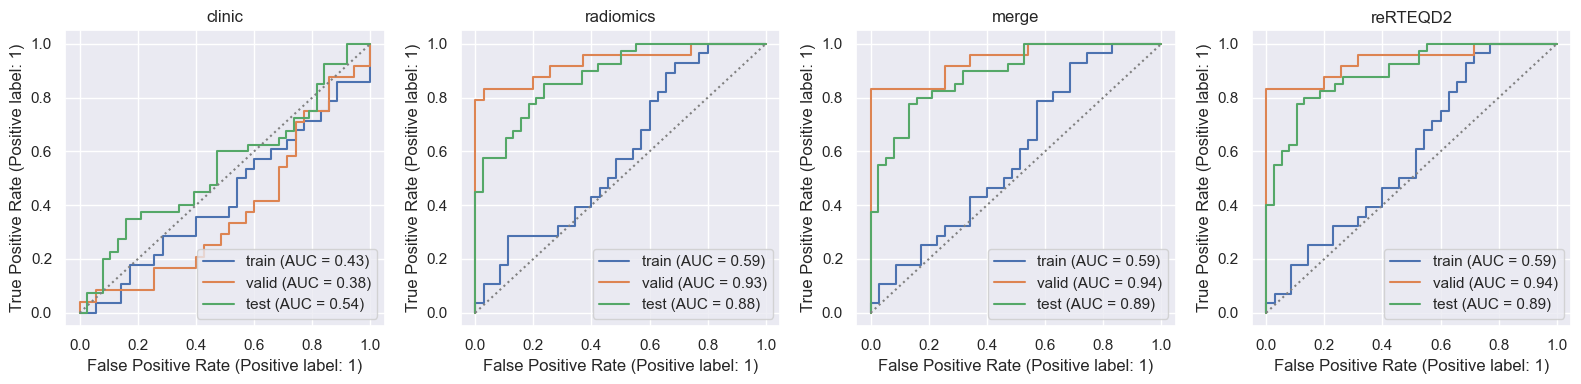

In [45]:
fig, ax = plt.subplots(1, 4, figsize = (16, 4))

order = ["clinic", "radiomics", "merge", ""]
order = exps

for i, name in enumerate(exps[:len(order)]):
    forest = forests[i]
    features = ([bin_cat + con] + features_list)[i]

    i = order.index(name)
    plot_roc_curve(forest, df_train.loc[:,features], df_train.loc[:,target_column], ax = ax[i], name = "train")
    plot_roc_curve(forest, df_valid.loc[:,features], df_valid.loc[:,target_column], ax = ax[i], name = "valid")
    plot_roc_curve(forest, df_test.loc[:,features], df_test.loc[:,target_column], ax = ax[i], name = "test")

    ax[i].plot((0, 1), (0, 1), linestyle = ":", color = "gray")
    ax[i].set_title(name)

fig.tight_layout()
# fig.savefig("./results/models_auc_sens.pdf", bbox_inches = "tight")
plt.show(fig)
plt.close(fig)

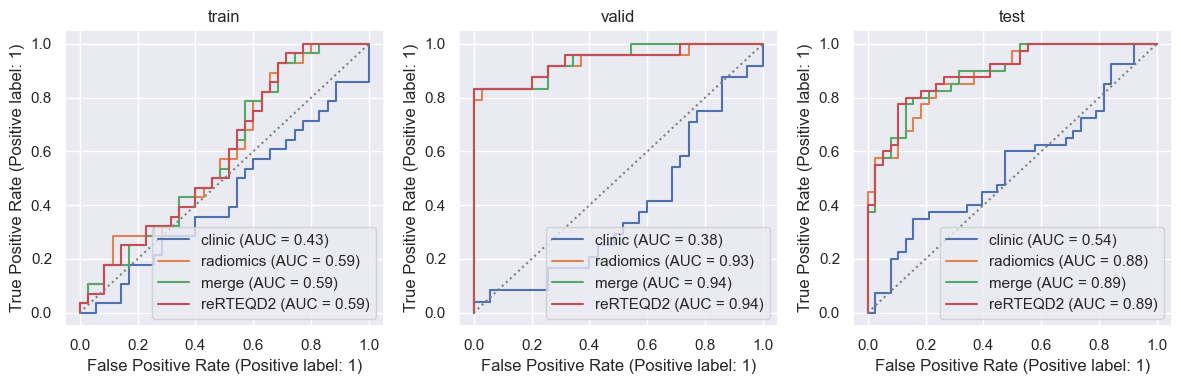

In [46]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))
for i, name in enumerate(exps[:4]):
    forest = forests[i]
    features = ([bin_cat + con] + features_list)[i]

    plot_roc_curve(forest, df_train.loc[:,features], df_train.loc[:,target_column], ax = ax[0], name = name)
    plot_roc_curve(forest, df_valid.loc[:,features], df_valid.loc[:,target_column], ax = ax[1], name = name)
    plot_roc_curve(forest, df_test.loc[:,features], df_test.loc[:,target_column], ax = ax[2], name = name)

ax[0].plot((0, 1), (0, 1), linestyle = ":", color = "gray")
ax[0].set_title("train")
ax[1].plot((0, 1), (0, 1), linestyle = ":", color = "gray")
ax[1].set_title("valid")
ax[2].plot((0, 1), (0, 1), linestyle = ":", color = "gray")
ax[2].set_title("test")

fig.tight_layout()
# fig.savefig("./results/train_test_auc_sens.pdf", bbox_inches = "tight")
plt.show(fig)
plt.close(fig)

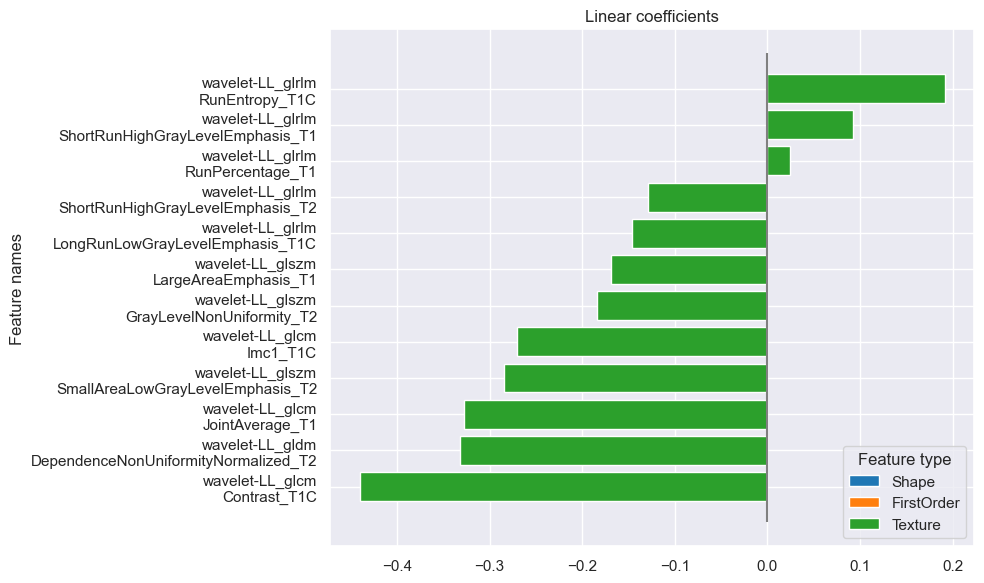

In [47]:
features = select_features[0] + select_features[1] + select_features[2]
imp = forests[i].feature_importances_

coefs = []
for feature in features:
    lm = LogisticRegression()
    lm.fit(df_train[[feature]], df_train.loc[:,target_column])
    coefs.append(lm.coef_[0,0])
    
sort_features = ["{}_{}\n{}_{}".format(*features[_].split("_")) for _ in np.argsort(coefs)]
sort_coefs = [coefs[_] for _ in np.argsort(coefs)]
types = [0 if "shape" in _ else 1 if "firstorder" in _ else 2 for _ in sort_features]
type_colors = [0, 1, 2]
type_names = ["Shape", "FirstOrder", "Texture"]
    
fig, ax = plt.subplots(figsize = (10, 6))


for a, b, i, j in zip(sort_features, sort_coefs, type_colors, type_names): #Loop over color dictionary
    ax.barh(a, b, height = 0, color = cmap(i), label = j) #Plot invisible bar graph but have the legends specified
ax.legend(title = "Feature type", loc = "lower right")

ax.barh(sort_features, sort_coefs, color = [cmap(_) for _ in types])
ax.vlines(0, *ax.get_ylim(), color = "gray")
# forest_importances.plot.bar(yerr = std, ax=ax

ax.set_title("Linear coefficients")
ax.set_ylabel("Feature names")

fig.tight_layout()
# fig.savefig("./results/feature_importance_sens.pdf", bbox_inches = "tight")
plt.show(fig)
plt.close(fig)

['u107', 'u66', 'u19', 'u58', 'u35', 'u48']


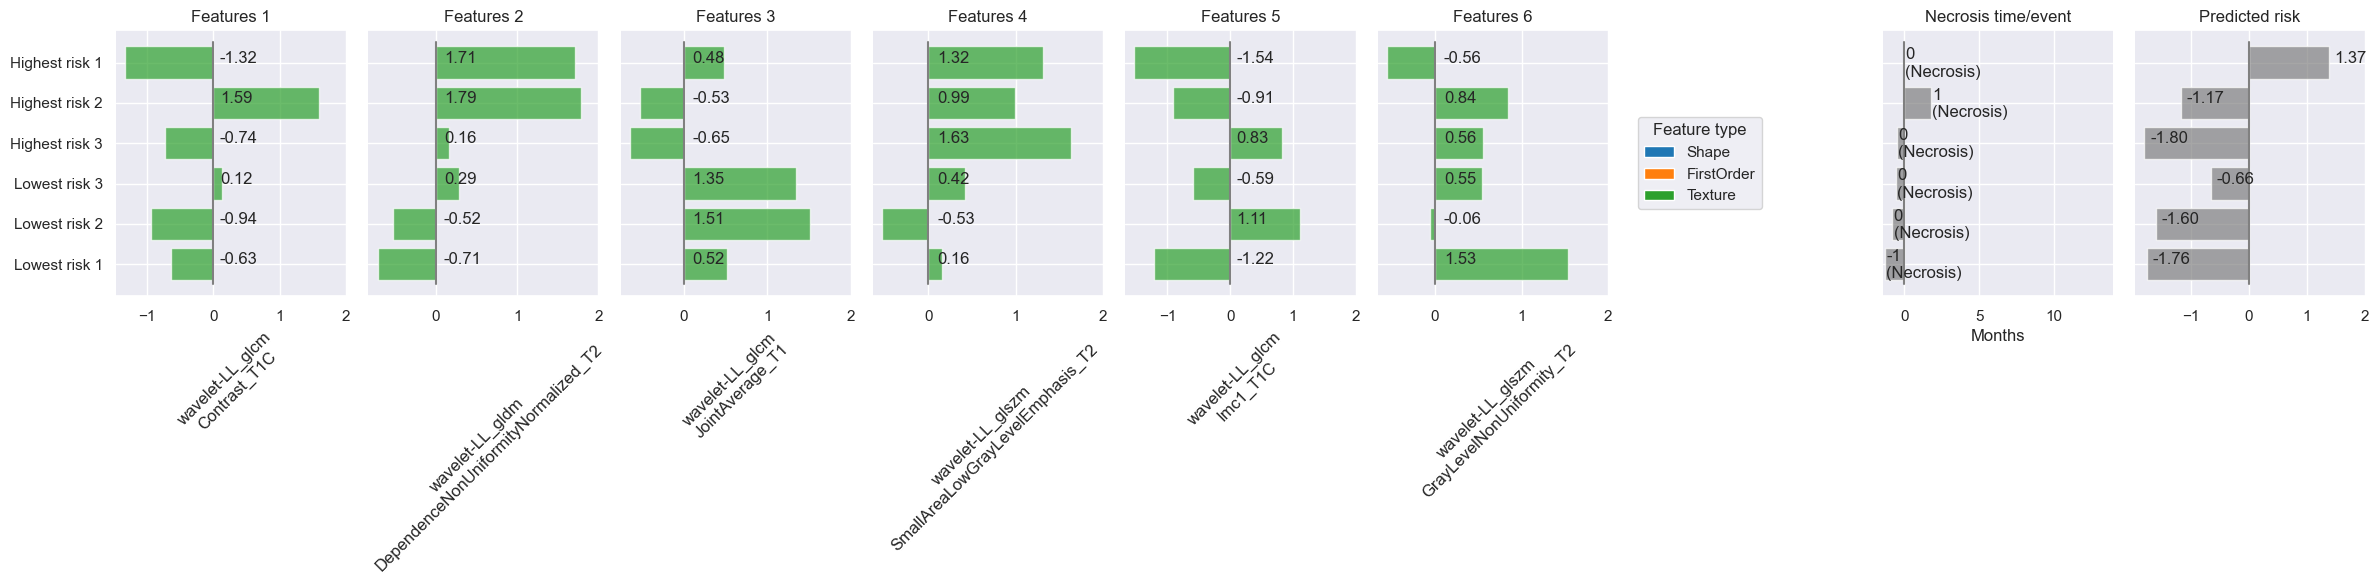

In [48]:
features = select_features[0] + select_features[1] + select_features[2]
features = [features[_] for _ in np.argsort(coefs)]
d = pd.concat([df_train, df_valid, df_test]).reset_index(drop = True)
# d = d[d.necro_rate = 1]
d = d.loc[:, features + ["necro_rate", "necro_time", "radiomics_score"]]
d = np.array(d)
d = d[np.argsort(d[:,-1])][[1,2,4,-4,-2,-1]]

fig, ax = plt.subplots(1, 9, figsize = (24, 6))
fig.patch.set_facecolor('white')

for i in range(8):
    if i == 6:
        for a, b, _, __ in zip([0] * 3, [0] * 3, type_colors, type_names):
            ax[i].barh(a, b, height = 0, color = cmap(_), label = __) #Plot invisible bar graph but have the legends specified
        ax[i].legend(title = "Feature type", loc = "center left")
        ax[i].axis("off")
    if i >= 6: i += 1
    ax[i].barh(range(6), d[:,i], color = cmap(types[i]) if i < 6 else "gray", alpha = 0.7)
    if i < 6:
        ax[i].set_title(f"Features {i+1}")
    elif i == 7:
        ax[i].set_title("Necrosis time/event")
    elif i == 8:
        ax[i].set_title("Predicted risk")
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].tick_params(left = False)
    ax[i].plot([0, 0], [-0.5, 5.5], color = "gray")
    for j in range(6):
        if i == 7:
            ax[i].text(d[j,i] + 0.1, j - 0.35, f"{int(d[j,i])}\n({'No n' if d[j,i - 1] == 0 else 'N'}ecrosis)")
            ax[i].set_xlim(ax[i].get_xlim()[0], ax[i].get_xlim()[1] + 2)
            ax[i].set_xlabel("Months")
        elif i == 8:
            ax[i].text(d[j,i] + 0.1, j, f"{d[j,i]:.2f}")
            ax[i].set_xlim(ax[i].get_xlim()[0], max(ax[i].get_xlim()[1], 2))
            pass
#             ax[i].text(d[j,i] + 0.1, j - 0.35, f"{int(d[j,i])}\n({'No n' if d[j,i - 1] == 0 else 'N'}ecrosis)")
#             ax[i].set_xlim(ax[i].get_xlim()[0], ax[i].get_xlim()[1] + 2)
#             ax[i].set_xlabel("Months")
        else:
            ax[i].text(0.1, j, f"{d[j,i]:.2f}")
            ax[i].set_xlim(ax[i].get_xlim()[0], max(ax[i].get_xlim()[1], 2))
            ax[i].set_xlabel(sort_features[i], rotation = 45)
    if i != 0:
        ax[i].tick_params(labelleft = False)
    else:
        ax[i].set_yticklabels([
            "", *[f"Lowest risk {j}" for j in range(1, 4)], 
            *[f"Highest risk {j}" for j in range(3, -1, -1)], ""])
        
print(pd.concat([df_train, df_valid, df_test]).sort_values("radiomics_score").reset_index(drop = True).iloc[[1,2,4,-4,-2,-1]].patient_id.tolist())
        
fig.tight_layout()
# fig.savefig("./results/feature_example.pdf", bbox_inches = "tight")
plt.show(fig)
plt.close(fig)

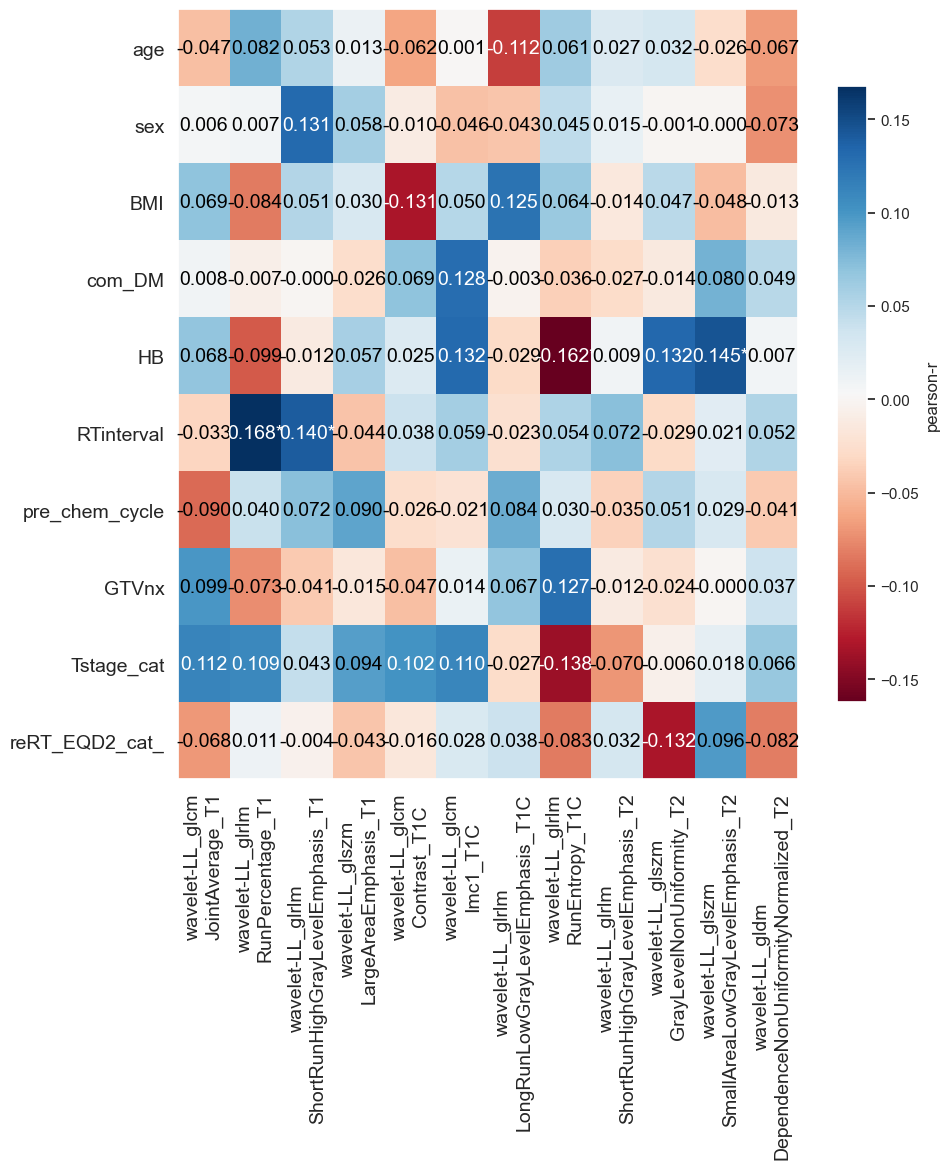

In [49]:
bin_cat2 = ["sex", "pre_necro", "Tstage_cat", "Nstage_cat", "com_DM", "com_HT", "pre_chem",
          "rIC", "rCCT", "rEGFR", "rVEGFR", "rIMMUNE", "reRT_type"]
multi_cat2 = ["location", "firstRT_type", "rPathology", "reRT_pro"]
con2 = ["age", "pre_chem_cycle", "RTinterval", "reRT_EQD2", "GTVnx", "HB", "BMI"]
all_cat = bin_cat2

for f in con2:
    df[f + "_cat_"] = (df[f] > np.median(df[f])).astype(int)
    all_cat.append(f + "_cat_")
    
all_cat = ["age_cat", "sex", "BMI_cat", "com_DM", "HB_cat", "ALB_cat_", "CRP_cat_", "firstRT_EQD2_cat_", "RTinterval_cat_", "pre_chem_cycle_cat_", "GTVnx_cat_", "Tstage_cat", "pre_necro"]
all_cat = ["age", "sex", "BMI", "com_DM", "HB", "RTinterval", "pre_chem_cycle", "GTVnx", "Tstage_cat", "reRT_EQD2_cat_"]

pvalues = np.zeros((len(all_cat), len(features_list[0]), 2))
for i, cat in enumerate(all_cat):
    uni = df[cat].unique()
    for j, f in enumerate(features_list[0]):
#         p = ttest_ind(df.loc[df[cat] == uni[0],f], df.loc[df[cat] == uni[1],f]).pvalue
        r, p = pearsonr(df.loc[:,cat], df.loc[:,f])
        pvalues[i, j] = [r, p]
        
fig, ax = plt.subplots(figsize = (10, 10))

_ = ax.imshow(pvalues[:,:,0], cmap = "RdBu", aspect = "auto")
_ = fig.colorbar(_, orientation = 'vertical', shrink = 0.8, label = "pearson-r")
# _.ax.set_yticklabels((-_.get_ticks()).round(1).astype(str))
ax.set_yticks(np.arange(len(all_cat)))
ax.set_yticklabels(all_cat, fontsize = 14)
ax.set_xticks(np.arange(len(features_list[0])))
xticklabels = [f"{x1}_{x2}\n{x3}_{x4}" for x1, x2, x3, x4 in [_.split("_") for _ in features_list[0]]]
ax.set_xticklabels(xticklabels, fontsize = 14, rotation = 90)
ax.grid(False)

for i in range(len(all_cat)):
    for j in range(len(features_list[0])):
        ax.text(j, i, 
                f"{round(pvalues[i, j, 0], 3):.3f}" + ("*" if pvalues[i, j, 1] < 0.05 else ""),
                horizontalalignment = "center", 
                verticalalignment = "center", 
                color = "black" if abs(pvalues[i, j, 0]) < 0.1 else "white", 
                fontsize = 14)


plt.show(fig)
# fig.savefig("./results/radiomics_clinic_correlation_heatmap.pdf", bbox_inches = "tight")
plt.close(fig)

In [51]:
fig, ax = plt.subplots(3, 4, figsize = (24, 15))
fig.patch.set_facecolor('white')

threses = [0.507, 0.7351, 0.7471, 0.7223]
dfs = [df_train, df_valid, df_test]
titles = ["train", "valid", "test"]
for i in (0, 1, 2):
    for j in range(len(exps)):
        df_ = dfs[i] # pd.concat([df_train, df_test])
        forest = forests[j]
        features = ([bin_cat + con] + features_list)[j]
        pred = forest.predict_proba(df_.loc[:,features])[:,1]# - thres
        thres = threses[j]
        pred -= thres

        order = np.argsort(pred)
        pred = pred[order]
        necro_rate = np.array(df_.necro_rate)[order]

        ax[i][j].bar(
            np.arange(len(pred))[necro_rate == 1], pred[necro_rate == 1], 
            width = 1, edgecolor = "black", 
            linewidth = 0, color = "tab:orange", label = "1-year w/ necrosis")
        ax[i][j].bar(
            np.arange(len(pred))[necro_rate == 0], pred[necro_rate == 0], 
            width = 1, edgecolor = "black", 
            linewidth = 0, color = "tab:blue", label = "1-year w/o necrosis")
        ax[i][j].vlines([np.argmin(np.abs(pred))], *ax[i][j].get_ylim(), color = "gray", linestyle = ":")
        ax[i][j].text(
            np.argmin(np.abs(pred)) - 0.01 * len(pred), 
            ax[i][j].get_ylim()[0] * 0.9 + ax[i][j].get_ylim()[1] * 0.1, 
            "Low risk", ha = 'right')
        ax[i][j].text(
            np.argmin(np.abs(pred)) + 0.01 * len(pred), 
            ax[i][j].get_ylim()[0] * 0.9 + ax[i][j].get_ylim()[1] * 0.1, 
            "High risk")
        ax[i][j].set_xlabel("Patients")
        ax[i][j].set_ylabel("Probability")
        ax[i][j].set_yticklabels(["", *[str(round(_ + thres, 3)) for _ in ax[i][j].get_yticks()[1:-1]], ""])
        ax[i][j].legend()
        ax[i][j].set_title(titles[i] + "-" + exps[j])

# fig.savefig("./results/patient_probability.pdf")
# plt.show(fig)
plt.close(fig)

In [53]:
radiomics_score = preds[1][0]
ticks = np.linspace(radiomics_score.min(), radiomics_score.max(), 6, endpoint = True)
breaks = np.linspace(radiomics_score.min(), radiomics_score.max(), 50, endpoint = True)[1:-1]
time_points = (6, 12, 24)
necro_ratio = np.zeros((len(time_points), len(breaks)))
for i, time_point in enumerate(time_points):
    for j, brk in enumerate(breaks):
        ratio = ((df_train[radiomics_score > brk].necro_time < time_point) & (df_train[radiomics_score > brk].necro_event == 1)).mean()
        necro_ratio[i, j] = ratio

fig, ax = plt.subplots(figsize = (6, 4))
fig.patch.set_facecolor('white')

for i, time_point in enumerate(time_points):
    x = breaks
    y = necro_ratio[i]
    # y = make_interp_spline(x, y)(np.linspace(x.min(), x.max(), 500))
    # x = np.linspace(x.min(), x.max(), 500)
    ax.plot(x, y, label = time_point)
ax.invert_xaxis()
ax.set_xlim(0.78, 0.3)
ax.vlines(0.7351, *ax.get_ylim(), color = "gray", linestyle = ":")
ax.text(0.71, ax.get_ylim()[1] - 0.2, "cutoff = 0.735")
ax.set_xlabel("radiomics score")
ax.set_ylabel("Probability of necrosis")
ax.legend(title = "month")

# fig.savefig("./results/nonecrosis_probability.pdf")
# plt.show(fig)
plt.close(fig)